<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluating-Imbalanced-Datasets" data-toc-modified-id="Evaluating-Imbalanced-Datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Evaluating Imbalanced Datasets</a></span><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Class-Weighting" data-toc-modified-id="Class-Weighting-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Class Weighting</a></span></li><li><span><a href="#F1-Score" data-toc-modified-id="F1-Score-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>F1 Score</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib

Ethen 2018-06-16 11:54:30 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.4
pandas 0.23.0
sklearn 0.19.1
matplotlib 2.2.2


# Evaluating Imbalanced Datasets

This documentation illustrates the trade off between True Positive Rate and False Positive Rate using ROC and Precision/Recall (PR) curves. In the end, we will take a look at why, for binary classification problem, apart from solely using the popular evaluation metric ROC curve we should also look at other evaluation metric such as precision and recall especially when working with highly imbalanced dataset.

## Dataset

The dataset we'll be using today can be downloaded from the [Kaggle website](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [3]:
filepath = os.path.join('data', 'creditcard.csv')
df = pd.read_csv(filepath)
print('dimension: ', df.shape)
df.head()

dimension:  (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


A brief description of the dataset based on the data overview section from the download source.

> The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.
> Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The only feature-engineering that we'll be doing for now is to convert the feature "Time" (seconds from which the very first data observation took place) to hours of a day. While we're at it, let's take a look at a breakdown of our legit vs fraud transactions via a pivot table and a plot of fraud transactions' count over time for a quick exploratory data analysis.

In [4]:
df['hour'] = np.ceil(df['Time'].values / 3600) % 24
fraud_over_hour = df.pivot_table(values = 'Amount', index = 'hour', columns = 'Class', aggfunc = 'count')
fraud_over_hour

Class,0,1
hour,,
0.0,10919,21
1.0,7687,6
2.0,4212,10
3.0,3269,57
4.0,3476,17
5.0,2185,23
6.0,2979,11
7.0,4093,9
8.0,7219,23


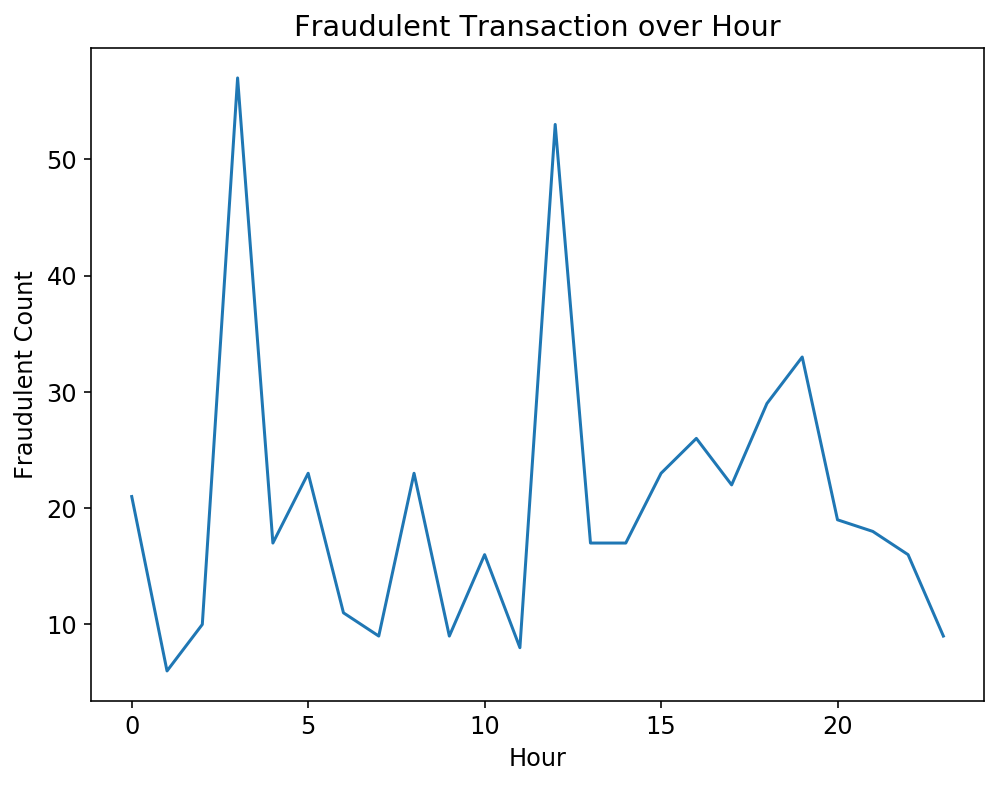

In [5]:
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 8, 6


plt.plot(fraud_over_hour.index, fraud_over_hour[1])
plt.title('Fraudulent Transaction over Hour')
plt.ylabel('Fraudulent Count')
plt.xlabel('Hour')
plt.show()

In [6]:
# prepare the dataset for modeling;
# extract the features and labels, perform a quick train/test split
label = df['Class']
pca_cols = [col for col in df.columns if col.startswith('V')]
input_cols = ['hour', 'Amount'] + pca_cols
df = df[input_cols]

df_train, df_test, y_train, y_test = train_test_split(
    df, label, stratify = label, test_size = 0.35, random_state = 1)

print('training data dimension:', df_train.shape)
df_train.head()

training data dimension: (185124, 30)


,hour,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
183716,11.0,0.76,2.089242,0.629632,-3.364200,0.489395,1.553483,-0.986382,0.698731,-0.284807,...,0.084549,-0.107484,-0.041904,0.058986,-0.103786,0.050964,0.416364,0.694420,-0.082845,-0.028126
145898,1.0,0.49,-0.914450,2.361973,0.335526,4.114377,0.557196,0.874183,0.332492,0.540016,...,1.614699,0.352808,-0.159933,-0.261357,0.186308,0.718244,-0.911284,-0.093219,-0.282263,-0.229368
247003,19.0,2.69,2.070918,-0.062049,-1.128898,0.383220,-0.079241,-1.130912,0.177956,-0.321792,...,0.201919,-0.222333,-0.299237,-0.732516,0.322038,-0.112259,-0.281414,0.205225,-0.071557,-0.061429
56024,14.0,159.95,0.929003,-0.262584,-0.026089,0.596927,-0.469012,-1.022218,0.463968,-0.176288,...,0.278433,0.152181,-0.236715,-1.149710,0.035834,0.504788,0.139781,0.095334,-0.102652,0.025986
217153,16.0,44.22,1.831384,-0.814800,-0.727692,-0.075094,0.028202,1.380668,-0.941283,0.502667,...,-1.051171,-0.240155,0.242974,0.905053,0.189693,-0.540499,-0.358400,0.202675,0.048368,-0.044683


In [7]:
# we'll be using linear models later, hence
# we standardize our features to ensure they are
# all at the same scale
standardize = StandardScaler()
X_train = standardize.fit_transform(df_train)
X_test = standardize.transform(df_test)

label_distribution = np.bincount(label) / label.size
print('labels distribution:', label_distribution)
print('Fraud is {}% of our data'.format(label_distribution[1] * 100))

labels distribution: [0.99827251 0.00172749]
Fraud is 0.1727485630620034% of our data


## Class Weighting

With scikit-learn, we can give higher weights to the minority class (the model will be penalized more when misclassifying a minority class) by modifying the `class_weight` argument during model initialization. Let's see what affect will this have with our model. The following code chunk manually selects a range of weights to boost the minority class and tracks various metrics to see the model's performance across different class weighting values.

Note that the following section assumes knowledge of model performance metric such as precision, recall and AUC. The following link contains resources into those concepts if needed. [Notebook: AUC (Area under the ROC curve and precision/recall curve) from scratch](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/model_selection/auc/auc.ipynb)

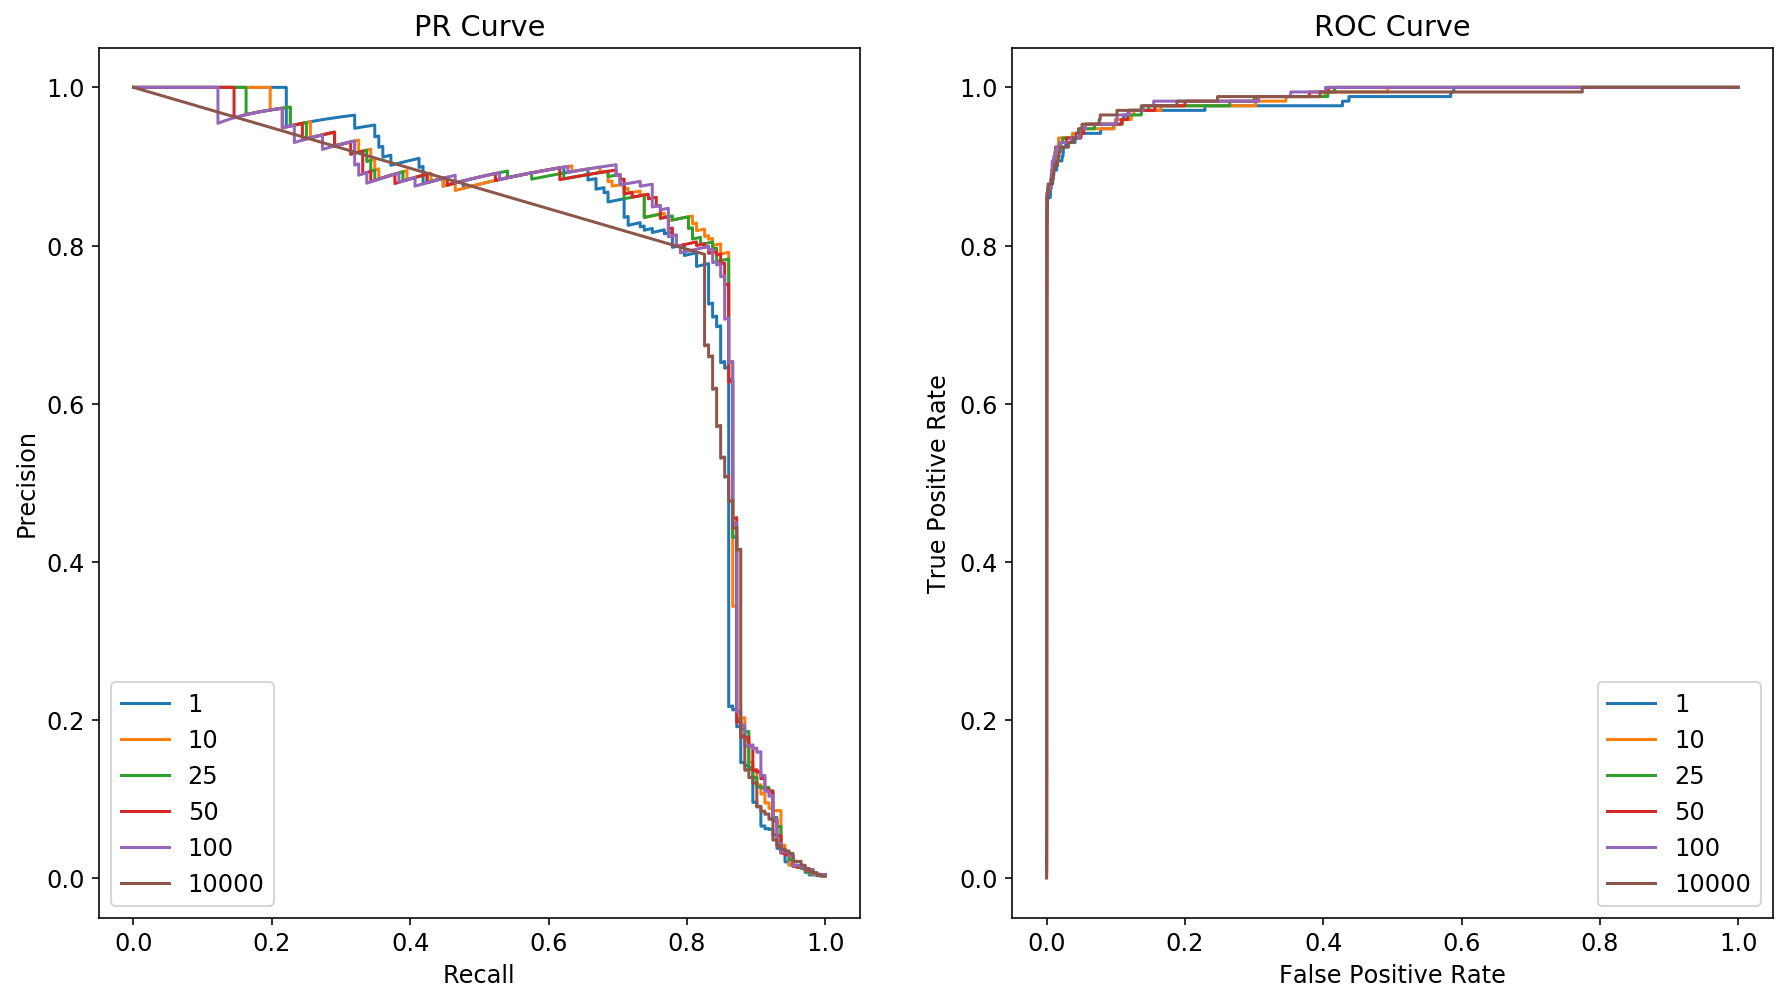

In [8]:
fig = plt.figure(figsize = (15, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

f1_scores = []
recall_scores = []
precision_scores = []
pos_weights = [1, 10, 25, 50, 100, 10000]
for pos_weight in pos_weights:
    lr_model = LogisticRegression(class_weight = {0: 1, 1: pos_weight})
    lr_model.fit(X_train, y_train)

    # plot the precision-recall curve and AUC curve
    pred_prob = lr_model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, pred_prob)
    tpr, fpr, _ = roc_curve(y_test, pred_prob)

    ax1.plot(recall, precision, label = pos_weight)
    ax2.plot(tpr, fpr, label = pos_weight)

    # track the precision, recall and f1 score
    pred = lr_model.predict(X_test)
    f1_test = f1_score(y_test, pred)
    recall_test = recall_score(y_test, pred)
    precision_test = precision_score(y_test, pred)
    f1_scores.append(f1_test)
    recall_scores.append(recall_test)
    precision_scores.append(precision_test)

ax1.legend(loc = 'lower left')    
ax2.legend(loc = 'lower right')

plt.show()

A good classifier would have a PR (Precision/Recall) curve closer to the upper-right corner and a ROC curve to the upper-left corner. Based on the plot above, we can see that while both curves uses the same underlying data, i.e. the real class labels and the predicted probability, the two charts can tell different stories, with some weights seem to perform better based on the ROC curve's chart.

To be explicit, different settings of the `class_weight` argument all seem to perform pretty well for ROC curve, but some poorly for PR curve. This is due to the fact that for ROC curve, one of the axis shows the false positive rate (number of false positives / total number of negatives), and this ratio will change much when the total number of negatives is large. Whereas for PR curve, one of the axis, precision (number of true positives / total number of predicted positives), is less affected by this.

Another way to visualize the model's performance metric is to use a bar-plot to visualize the precision/recall/f1 score at different class weighting values.

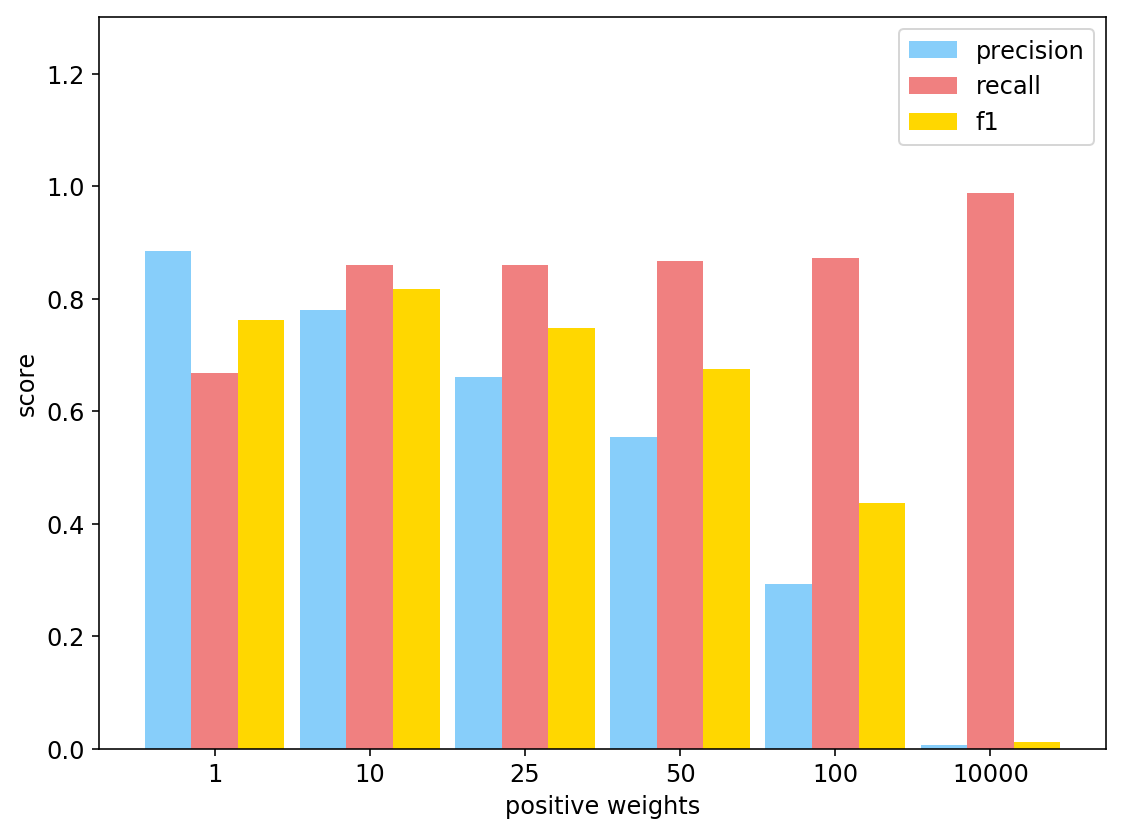

In [9]:
def score_barplot(precision_scores, recall_scores, f1_scores, pos_weights, figsize = (8, 6)):
    """Visualize precision/recall/f1 score at different class weighting values."""
    width = 0.3
    ind = np.arange(len(precision_scores))      
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    b1 = ax.bar(ind, precision_scores, width, color = 'lightskyblue')
    b2 = ax.bar(ind + width, recall_scores, width, color = 'lightcoral')
    b3 = ax.bar(ind + (2 * width), f1_scores, width, color = 'gold')

    ax.set_xticks(ind + width)
    ax.set_xticklabels(pos_weights)
    ax.set_ylabel('score')
    ax.set_xlabel('positive weights')
    ax.set_ylim(0, 1.3)
    ax.legend(handles = [b1, b2, b3], labels = ['precision', 'recall', 'f1'])
    plt.tight_layout()
    plt.show()


score_barplot(precision_scores, recall_scores, f1_scores, pos_weights)

Judging from the plot above, the can see that when the weight's value is set at 10, we seem to have strike a good balance between precision and recall (this setting has the highest f1 score, we'll have a deeper discussion on f1 score in the next section), where our model can detect 80% of the fraudulent transaction, while not annoying a bunch of customers with false positives. Another observation is that if we were to set the class weighting value to 10,000 we would be able to increase our recall score at the expense of more mis-classified legit cases (as depicted by the low precision score).

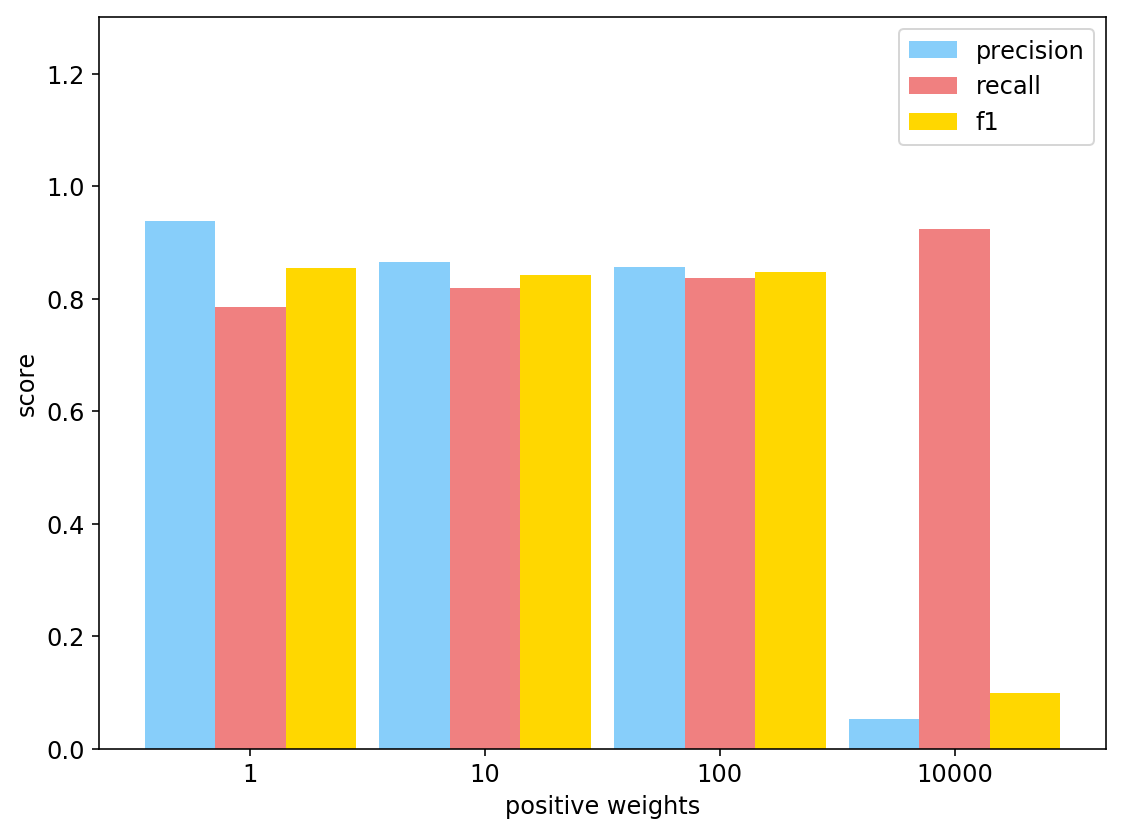

In [10]:
# this code chunk shows the same idea applies when using tree-based models
f1_scores = []
recall_scores = []
precision_scores = []
pos_weights = [1, 10, 100, 10000]
for pos_weight in pos_weights:
    rf_model = RandomForestClassifier(n_estimators = 50, max_depth = 6, n_jobs = -1,
                                      class_weight = {0: 1, 1: pos_weight})
    rf_model.fit(df_train, y_train)

    # track the precision, recall and f1 score
    pred = rf_model.predict(df_test)
    f1_test = f1_score(y_test, pred)
    recall_test = recall_score(y_test, pred)
    precision_test = precision_score(y_test, pred)
    f1_scores.append(f1_test)
    recall_scores.append(recall_test)
    precision_scores.append(precision_test)

score_barplot(precision_scores, recall_scores, f1_scores, pos_weights)

## F1 Score

The formula for F1 score is:

\begin{align}
F1 &= 2 * \frac{\text{precision} * \text{recall}}{\text{precision} + \text{recall}}
\end{align}

F1 score can be interpreted as a weighted average or harmonic mean of precision and recall, where the relative contribution of precision and recall to the F1 score are equal. F1 score reaches its best value at 1 and worst score at 0.

When we create a classifier, often times we need to make a compromise between the recall and precision, it is kind of hard to compare a model with high recall and low precision versus a model with high precision but low recall. F1 score merge these two metrics into a single measure that we can use to compare two models. This is not to say that a model with higher F1 score is always better as it depends on the use case, more on this in the conclusion section.

To understand the rationale behind harmonic means, let's digress from machine learning evaluation metrics and take a look at a canonical example of using harmonic means. Consider a trip to the grocery store & back:

- On the way there we drove 30 mph the entire way.
- On the way back traffic was crawling, so we instead drove 10 mph the entire way.
- We took the same route and covered the same amount of ground (5 miles) each way.

What was our average speed across this entire trip's duration? When prompted to calculate the average of something, we might naively turn to arithmetic mean to 30 mph and 10 mph and proudly declare that the average speed for the whole trip was 20 mph. But if we step back and think about it for a moment, we'll realize that because we traveled faster on our way there, we covered the 5 miles quicker & spent less time overall traveling at that speed, thus our average speed across our entire trip should be closer to 10 mph because we spent longer traveling at that speed. In order to calculate the arithmetic mean correctly here, we have to first calculate the amount of time spent traveling at each rate, then weight our mean calculation accordingly.

- Trip There: (at 30 mph)
    - 30 miles per 60 minutes = 1 mile every 2 minutes = 1/2 mile every minute
    - 5 miles at 1/2 mile per minute = 5 / 1/2 = 10 minutes
    - Trip There time = 10 minutes
- Trip Back: (at 10 mph)
    - 10 miles per 60 minutes = 1 mile every 6 minutes = 1/6 miles every minute
    - 5 miles at 1/6 mile per minute = 5 / 1/6 = 30 minutes
    - Trip Back time = 30 minutes
- Total trip time = 10 + 30 = 40 minutes
    - Trip there / total trip = 10 / 40 minutes = .25
    - Trip back / total trip = 30 / 40 minutes = .75
- Weighted Arithmetic Mean = (30 mph x .25) + (10 mph x .75) = 7.5 + 7.5 = 15 

We now get an average speed of 15 mph, which matches the intuition that the number should be lower than our unweighted arithmetic mean of 20 mph. Now let's look at the same problem from a harmonic mean perspective. The harmonic mean can be described in words as: the reciprocal of the arithmetic mean of the reciprocals of the dataset. That's a lot of reciprocal flips there ..., the notation for the computation is:

\begin{align}
\text{Harmonic mean} &= \big( \frac{\sum_{i=1}^n x_i^{-1}}{n} \big)^{-1}
\end{align}

Now back our original example, the harmonic mean of 30 mph and 10 mph:

- Arithmetic mean of reciprocals = 1/30 + 1/10 = 4/30 / 2 = 4/60 = 1/15
- Reciprocal of arithmetic mean = 1 / 1/15 = 15/1 = 15

Our true average rate of travel, automagically adjusted for time spent traveling in each direction = 15 mph! In this example, using harmonic mean helps us find relationship with datasets of rates/ratios/fractions over different length/periods. By using reciprocals, it already accounts for the proportion of time that was implicit in the rates.

With this knowledge in mind, let's turn our heads back to F1 score's calculation. Precision and recall both have true positives in the numerator, but they have different denominators. In order for an average to be valid, we need the values to be in the same scaled units. In our traveling distance example miles per hour need to be compared over the same number of hours. Thus, to take the average of precision and recall really only makes sense to average their reciprocals (adjusts for scale), thus the harmonic mean.

## Conclusion

To sum it up, when using model-based metrics to evaluate a imbalanced classification problem, it is often times recommended to look at the precision and recall score to fully evaluate the overall effectiveness of a model.

A model with high recall but low precision score returns many positive results, but most of its predicted labels are incorrect when compared to the ground truth. On the other hand, a model with high precision but low recall score returns very few results, but most of its predicted labels are correct when compared to the ground-truth. An ideal scenario would be a model with high precision and high recall, meaning it will return many results, with all results labeled correctly. Unfortunately, in most cases, precision and recall are often in tension. That is, improving precision typically reduces recall and vice versa.

So how do we know if we should sacrifice our precision for more recall, i.e. catching fraud? That is business decisions come into play. If the cost of missing a fraud highly outweighs the cost of canceling a bunch of legit customer transactions, i.e. false positives, then perhaps we can choose a weight that gives us a higher recall rate. Or maybe catching 80% of fraud is good enough for the business, in that case, we can also minimize the "user friction" by keeping our precision high.

# Reference

- [Notes: The Harmonic Mean](http://jwilson.coe.uga.edu/EMT725/HM/HM.html)
- [Blog: 
Classification: Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
- [Blog: On Average, You’re Using the Wrong Average: Geometric & Harmonic Means in Data Analysis](https://towardsdatascience.com/on-average-youre-using-the-wrong-average-geometric-harmonic-means-in-data-analysis-2a703e21ea0)
- [Kaggle Kernel: Imbalanced data & why you should NOT use ROC curve](https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve)
- [Stackoverflow: what is f1-score and what its value indicates?](https://stackoverflow.com/questions/45963174/what-is-f1-score-and-what-its-value-indicates)
- [Stackoverflow: Why is the F-Measure a harmonic mean and not an arithmetic mean of the Precision and Recall measures?](https://stackoverflow.com/questions/26355942/why-is-the-f-measure-a-harmonic-mean-and-not-an-arithmetic-mean-of-the-precision)